# Word Embedding: Genius Song Lyrics Subset (1%)

**Purpose:** Create and explore word embeddings.
**Details:** Uses tokenized data to generate embeddings, visualize semantic relationships, and analyze similarity between words.

---

# 1. Train Model
## 1.1 Load and prepare Data

In [1]:
import pandas as pd
import os
import re
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

**Relevante Spalten:**
- `language_cld3` — erkannte Sprache (typisch ISO-Code, z. B. `en` für Englisch)
- `tokens` — Liste der Token (Wörter) der Lyrics pro Zeile

**Hinweis:** Für Word2Vec müssen es **Listen von Strings** sein.

In [2]:
df = pd.read_csv("data/clean/data.csv")

df = df[df["language_cld3"] == "en"]

if isinstance(df["tokens"].iloc[0], str):
    df["tokens"] = df["tokens"].apply(ast.literal_eval)

sentences = df["tokens"].dropna().tolist()

## 1.2 Train Word2Vec Model

**Ziel:** Lernen von Wortvektoren aus den Lyrics-Token.
**Bibliothek:** `gensim.models.Word2Vec`

### Wichtige Parameter

| Parameter     | Bedeutung |
|----------------|------------|
| `sentences`    | Eingabedaten als Liste von Wortlisten (siehe Schritt 1) |
| `vector_size=50` | Dimension der Wortvektoren (kompakte Darstellung, schnelleres Training; ausreichend für einen ersten Durchlauf) |
| `window=5`     | Kontextfenster: betrachtet bis zu 5 Wörter **links und rechts** eines Zielworts → balanciert lokalen und mittleren Kontext |
| `min_count=2`  | Ignoriert seltene Wörter (< 2 Vorkommen) → reduziert Rauschen & Vokabulargröße |
| `workers=4`    | Nutzt 4 Threads zur Parallelisierung → schnelleres Training (abhängig von CPU) |
| `epochs=100`   | 100 Epochen (vollständige Durchläufe über die Daten) → stabilere Vektoren bei kleineren Datensätzen |


In [3]:
model = Word2Vec(
    sentences=sentences,
    vector_size=50,
    window=5,
    min_count=2,
    workers=4,
    epochs=100
)

print("Model trained!")
print("Vocabulary size:", len(model.wv))
print("Vector size:", model.wv.vector_size)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

Model trained!
Vocabulary size: 65504
Vector size: 50


**Ergebnis:** Ein trainiertes Word2Vec-Modell, das semantische Beziehungen zwischen Wörtern
in einem 50-dimensionalen Raum abbildet.

**Beispiele:** Ähnlichkeiten zwischen Wörtern (`model.wv.most_similar("love")`)

# 2. Explore Embedding Space
## 2.1 Embedding Examples: 'love'

In [4]:
word = "love"
if word in model.wv:
    print(f"\nVector for '{word}':", model.wv[word][:10])
    print("\nMost similar words to 'love':")
    print(model.wv.most_similar(word, topn=5))
else:
    print(f"'{word}' not in vocabulary.")


Vector for 'love': [-2.3213665  -1.8809512   0.7826385  -0.5758768  -0.17533624  2.923331
 -2.6103792  -5.4188247  -2.7076802   3.4935162 ]

Most similar words to 'love':
[('loving', 0.7922292947769165), ('baby', 0.7548907995223999), ('babe', 0.7192135453224182), ('everything', 0.7001785635948181), ('cause', 0.6958890557289124)]


In [5]:
def find_similar_words(word, model, top_n=5):
    if word not in model.wv:
        return None, None
    similar = model.wv.most_similar(word, topn=top_n)
    words = [w for w, _ in similar]
    scores = [s for _, s in similar]
    return words, scores


test_words = ["baby", "love", "happy"]

# Store results for plotting in next cell
similar_results = {}

for word in test_words:
    print(f"\n🔍 Finding words similar to '{word}'...")
    words, scores = find_similar_words(word, model, top_n=5)

    if words:
        similar_results[word] = (words, scores)

        for w, s in zip(words, scores):
            bar = '█' * int(s * 10)
            print(f"  {w:10} {bar} {s:.2f}")
    else:
        similar_results[word] = None
        print(f"  '{word}' not in vocabulary.")


🔍 Finding words similar to 'baby'...
  girl       ████████ 0.88
  babe       ████████ 0.83
  love       ███████ 0.75
  just       ███████ 0.75
  darlin     ███████ 0.74

🔍 Finding words similar to 'love'...
  loving     ███████ 0.79
  baby       ███████ 0.75
  babe       ███████ 0.72
  everything ███████ 0.70
  cause      ██████ 0.70

🔍 Finding words similar to 'happy'...
  glad       ███████ 0.74
  sad        ███████ 0.73
  sure       ██████ 0.65
  holidays   ██████ 0.62
  happier    ██████ 0.61


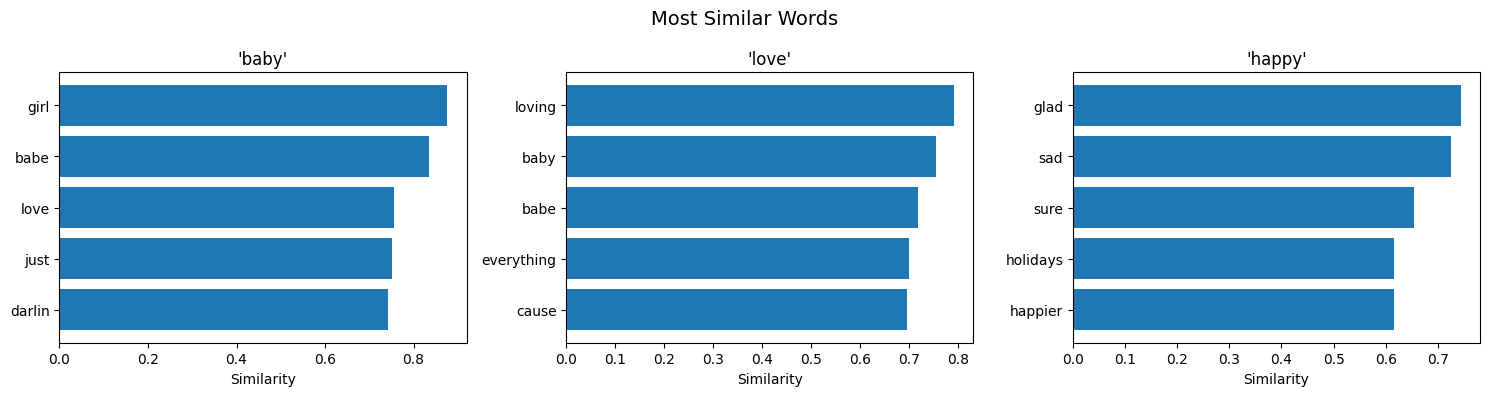

In [6]:
fig, axes = plt.subplots(1, len(test_words), figsize=(5 * len(test_words), 4))

# Handle single-axis case
if len(test_words) == 1:
    axes = [axes]

for ax, word in zip(axes, test_words):
    result = similar_results[word]

    if result:
        words, scores = result
        ax.barh(words, scores)
        ax.set_title(f"'{word}'")
        ax.set_xlabel("Similarity")
        ax.invert_yaxis()
    else:
        ax.set_visible(False)

fig.suptitle("Most Similar Words", fontsize=14)
fig.tight_layout()
plt.show()

Diese Funktion sucht nach den **ähnlichsten Wörtern** zu einem gegebenen Wort im Word2Vec-Modell.
Sie gibt zwei Listen zurück:

- **`words`** → die ähnlichsten Wörter
- **`scores`** → die Ähnlichkeitswerte (Kosinus-Ähnlichkeit, zwischen 0 und 1)

Wenn das Wort **nicht im Vokabular** vorhanden ist, wird **`(None, None)`** zurückgegeben.

**Ergebnis:**

`happy - sad`

→ Überraschend ähnlich, obwohl es Gegenteile sind.
**Warum?** Word2Vec versteht **Kontextähnlichkeit**, nicht logische Gegensätze.
Beide Wörter treten oft in ähnlichen Satzstrukturen auf:
> “I feel happy today.” / “I feel sad today.”
Daher liegen sie **räumlich nah**, obwohl sie **semantisch gegensätzlich** sind.

`happy - happier`

→ Grammatische Variante desselben Wortstamms („happy“ → „happier“).
Das Modell erkennt **Formverwandtschaften**.

`happy - sure`

→ Semantische Assoziation durch **gemeinsamen Kontext**:
> „happy holidays“, „feeling happy during holidays“
Wörter, die häufig **gemeinsam auftreten**, erhalten höhere Ähnlichkeitswerte.


In [7]:
def explore_similar_words(word, model, top_n=10):

    if word not in model.wv:
        raise ValueError(f"'{word}' not in model vocabulary.")


    similar = model.wv.most_similar(word, topn=top_n)
    words = [word] + [w for w, _ in similar]
    scores = [1.0] + [s for _, s in similar]


    vectors = np.array([model.wv[w] for w in words])


    if vectors.shape[1] > 3:
        pca = PCA(n_components=3)
        vectors_3d = pca.fit_transform(vectors)
        axis_titles = ("PC1", "PC2", "PC3")
    else:
        vectors_3d = vectors
        axis_titles = tuple(f"Dim{i+1}" for i in range(vectors.shape[1]))


    sizes = np.array(scores) * 25
    colors = np.array(scores)


    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=vectors_3d[:, 0],
                y=vectors_3d[:, 1],
                z=vectors_3d[:, 2] if vectors_3d.shape[1] > 2 else np.zeros(len(words)),
                mode="markers+text",
                text=words,
                textposition="top center",
                marker=dict(
                    size=sizes,
                    color=colors,
                    colorscale="viridis",
                    showscale=True,
                    colorbar=dict(title="Similarity"),
                    line=dict(width=1, color="black"),
                    symbol=["diamond"] + ["circle"] * (len(words) - 1)
                ),
                hovertemplate="<b>%{text}</b><br>Similarity: %{marker.color:.2f}<extra></extra>",
            )
        ]
    )

    fig.update_layout(
        title=f"Similar Words to '{word}' (Top {top_n}) — Color/Size = Similarity",
        scene=dict(
            xaxis_title=axis_titles[0],
            yaxis_title=axis_titles[1],
            zaxis_title=axis_titles[2],
        ),
        height=600,
        margin=dict(l=0, r=0, t=40, b=0),
    )

    return fig



fig = explore_similar_words("love", model, top_n=30)
fig.show()

**Analys:** Das Wort *love*

Diese Funktion zeigt, **wie nah verwandte Wörter im semantischen Raum** zueinander liegen.
Hier das Beispielwort **"love"**.

| Vergleich | Distanz | Warum |
|------------|----------|-------|
| love ↔ loving | sehr gering | gleiche Wortfamilie, gleicher Kontext (Verbformen) |
| love ↔ baby | etwas größer | thematisch ähnlich, aber anderer Satzgebrauch |

**Semantische Zonen:**

| Bereich | Wörter | Bedeutung |
|----------|---------|------------|
|  **Zentrum** | love, loving, lov, loves | direkter Wortstamm (höchste Ähnlichkeit) |
|  **Links-Vorne** | baby, babe, darling, girl, heart | emotionale / beziehungsbezogene Substantive |
|  **Rechts-Oben** | forever, never, always, ever | zeitliche oder abstrakte Begriffe |
|  **Mitte** | want, feel, know, say, cause | häufige Verben im emotionalen Kontext |
|  **Unten** | believe, true | Begriffe aus dem semantischen Feld „Vertrauen / Wahrheit“ |

Beispielinterpretationen:
- `love ↔ loving` → gleicher semantischer Kern, ähnliche Satzstruktur (Verbform)
- `love ↔ loves` → gleiche Bedeutung, anderer grammatikalischer Kontext

## 2.2 Embedding Space

In [8]:
def explore_embedding_space(model, n_words=30):
    vocab = list(model.wv.index_to_key)
    if len(vocab) == 0:
        raise ValueError("The model has an empty vocabulary.")
    n = min(n_words, len(vocab))
    words = vocab[:n]

    vectors = np.array([model.wv[w] for w in words])

    if vectors.shape[1] > 3:
        pca = PCA(n_components=3)
        vectors_3d = pca.fit_transform(vectors)
        axis_titles = ("PC1", "PC2", "PC3")
    else:
        vectors_3d = vectors
        axis_titles = tuple(f"Dim{i+1}" for i in range(vectors.shape[1]))

    distances = np.linalg.norm(vectors_3d, axis=1)

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=vectors_3d[:, 0],
                y=vectors_3d[:, 1] if vectors_3d.shape[1] > 1 else np.zeros_like(distances),
                z=vectors_3d[:, 2] if vectors_3d.shape[1] > 2 else np.zeros_like(distances),
                mode="markers+text",
                text=words,
                textposition="top center",
                marker=dict(
                    size=np.clip(distances * 3, 4, 24),
                    color=distances,
                    colorscale="Viridis",
                    showscale=True,
                    colorbar=dict(title="Distance"),
                ),
                hovertemplate="<b>%{text}</b><br>Distance: %{marker.color:.2f}<extra></extra>",
            )
        ]
    )

    fig.update_layout(
        title=f"Explore the Word Space (Top {n} words) — Size/Color = Distance from Origin",
        scene=dict(
            xaxis_title=axis_titles[0],
            yaxis_title=axis_titles[1] if len(axis_titles) > 1 else "",
            zaxis_title=axis_titles[2] if len(axis_titles) > 2 else "",
        ),
        height=600,
        margin=dict(l=0, r=0, t=40, b=0),
    )

    return fig

fig = explore_embedding_space(model, n_words=50)
fig.show()

**3D-Visualisierung der Wortvektoren:**

Diese Funktion erzeugt eine **3D-Visualisierung** der Wortvektoren aus dem trainierten Word2Vec-Modell.

Da Word2Vec-Vektoren meist **50–300 Dimensionen** haben, wird eine **Hauptkomponentenanalyse (PCA)** durchgeführt,
um die Daten auf **3 Dimensionen** zu reduzieren.

**Funktionsweise:**

- Berechnet für jedes Wort den **Abstand vom Ursprung (0, 0, 0)** im 3D-Raum.
- Farbe und Größe der Punkte basieren auf diesem Abstand.
- Wörter mit ähnlicher Bedeutung oder gleichem Kontext liegen **nah beieinander**.

| Aspekt | Bedeutung |
|--------|------------|
| **Position** | Semantische Lage im Raum — Wörter mit ähnlichem Kontext liegen nah beieinander |
| **Abstand** | Maß für semantische Ähnlichkeit — je näher, desto ähnlicher |
| **Farbe** | basiert auf Distanz vom Ursprung (Dunkelblau = nah, Gelb/Grün = weit entfernt) |
| **Größe** | proportional zur Distanz — größere Punkte = auffälligere, semantisch ausgeprägte Wörter |

**Beispielhafte Cluster**

- **Linke Seite:** „come“, „let“, „go“, „here“, „right“, „where“, „back“ → Funktions- oder Aktionsverben
- **Rechte Seite:** „bitch“, „fuck“, „shit“ → Vulgär- / Emotionalkontext
- **Zentrum:** „baby“, „love“, „wanna“, „think“ → emotionale, umgangssprachliche Wörter

Das Modell hat gelernt, dass bestimmte Wortgruppen ähnliche Verwendungen haben,
selbst wenn ihre **Bedeutung unterschiedlich** ist.

Die Funktion **`explore_doc_space()`** zeigt,
**wie ähnlich oder unterschiedlich Songtexte zueinander sind**, basierend auf ihren **Embeddings**.

- Jeder Punkt = ein **Song (Dokument)**
- **Nähe zweier Punkte** → ähnliche Wortverwendungen oder Themen
- **Farbe & Größe** → Distanz vom Ursprung (semantische „Charakteristik“ des Songs)
- **Cluster** → Gruppen von Songs mit ähnlichem Inhalt, Stimmung oder Vokabular

 Damit wird sichtbar, **welche Songs sich thematisch ähneln**,
> z. B. Liebeslieder, Partytracks oder melancholische Texte.

# 3. TF-IDF

In [9]:
tfidf_vect = TfidfVectorizer(
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False
)

X_tfidf = tfidf_vect.fit_transform(df["tokens"])
terms = tfidf_vect.get_feature_names_out()

dim = model.wv.vector_size
doc_emb_tfidf = np.zeros((X_tfidf.shape[0], dim), dtype=np.float32)

for i in range(X_tfidf.shape[0]):
    row = X_tfidf[i]
    if row.nnz == 0:
        continue
    idxs = row.indices
    wts = row.data
    vecs = []
    w = []
    for j, wt in zip(idxs, wts):
        term = terms[j]
        if term in model.wv:
            vecs.append(model.wv[term])
            w.append(wt)
    if w:
        vecs = np.vstack(vecs)
        w = np.asarray(w, dtype=np.float32)
        doc_emb_tfidf[i] = (vecs * w[:, None]).sum(axis=0) / (w.sum() + 1e-9)

print("TF-IDF-Embeddings:", doc_emb_tfidf.shape)

# Optional: Nullvektoren rausfiltern (falls ein Song keine bekannten Wörter hat)
keep = np.linalg.norm(doc_emb_tfidf, axis=1) > 0
df_use = df.reset_index(drop=True).loc[keep].reset_index(drop=True)
emb_use = doc_emb_tfidf[keep]
print("Nach Filter:", emb_use.shape)

TF-IDF-Embeddings: (34049, 50)
Nach Filter: (34049, 50)


**Dokument-Vektoren mit Word2Vec & TF-IDF**

**Ziel**
Für jedes Dokument (z. B. Songtext) wird ein **repräsentativer Vektor** berechnet,
der die Bedeutung aller Wörter kombiniert – **gewichtet nach ihrer Wichtigkeit**.

**Einstellungen**
| Parameter | Bedeutung |
|------------|------------|
| `tokenizer=lambda x: x` | Verwendet die vorhandene Tokenliste (nicht erneut splitten) |
| `preprocessor=lambda x: x` | Kein Text-Cleaning oder Joinen |
| `token_pattern=None` | Deaktiviert die Standardtokenizer-Regel von sklearn |
| `lowercase=False` | Tokens bleiben in ihrer ursprünglichen Form (Groß-/Kleinschreibung bleibt erhalten) |

**Konzept**
- **Word2Vec** → fängt **semantische Beziehungen** zwischen Wörtern ein
- **TF-IDF (Term Frequency – Inverse Document Frequency)** → hebt **wichtige Wörter** hervor

# 4. Embedding of whole songs

In [10]:
GENRE_COL = "tag"

def get_song_vector(tokens, w2v_model):
    """
    Compute a single vector representation for one song by
    averaging all word vectors for its tokens.
    If no token is in the vocabulary, return a zero vector.
    """
    if not isinstance(tokens, (list, tuple)):
        return np.zeros(w2v_model.vector_size, dtype=np.float32)

    vectors = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]

    if not vectors:
        return np.zeros(w2v_model.vector_size, dtype=np.float32)

    return np.mean(vectors, axis=0).astype(np.float32)

# Keep only rows that have tokens and a genre label
df_songs = df.dropna(subset=["tokens", GENRE_COL]).copy()

# Compute one embedding per song
df_songs["embedding"] = df_songs["tokens"].apply(
    lambda toks: get_song_vector(toks, model)
)

# Stack into feature matrix X and label array y
X = np.vstack(df_songs["embedding"].values)        # shape: (n_songs, embedding_dim)
y = df_songs[GENRE_COL].astype(str).values         # shape: (n_songs,)

print("Song embeddings shape:", X.shape)
print("Number of songs:", len(y))
print("Example genres:", y[:10])


Song embeddings shape: (34049, 50)
Number of songs: 34049
Example genres: ['rap' 'rap' 'rock' 'rock' 'misc' 'rock' 'pop' 'rb' 'rap' 'rap']


In [11]:
def explore_doc_space(embeddings, labels=None, n_max=None):
    """
    Interaktiver 3D-Plot von Dokument-/Song-Embeddings.
    Nutzt ggf. PCA auf 3 Dimensionen und färbt/skalieren nach Distanz vom Ursprung.
    """

    if embeddings is None or len(embeddings) == 0:
        raise ValueError("Keine Embeddings übergeben.")

    X = np.asarray(embeddings)
    if n_max is not None:
        X = X[:n_max]
        if labels is not None:
            labels = labels[:n_max]

    # Auf 3 Dimensionen reduzieren (falls nötig)
    if X.shape[1] > 3:
        pca = PCA(n_components=3)
        X3 = pca.fit_transform(X)
        axis_titles = ("PC1", "PC2", "PC3")
    else:
        X3 = X
        axis_titles = tuple(f"Dim{i+1}" for i in range(X.shape[1]))
        # ggf. auf 3 Achsen auffüllen
        if X3.shape[1] == 1:
            X3 = np.hstack([X3, np.zeros((X3.shape[0], 2))])
        elif X3.shape[1] == 2:
            X3 = np.hstack([X3, np.zeros((X3.shape[0], 1))])

    # Distanz vom Ursprung → für Marker-Größe/Farbe
    distances = np.linalg.norm(X3, axis=1)

    if labels is None:
        labels = [f"Doc {i}" for i in range(X3.shape[0])]

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=X3[:, 0],
                y=X3[:, 1],
                z=X3[:, 2],
                mode="markers+text",
                text=labels,
                textposition="top center",
                marker=dict(
                    size=np.clip(distances * 3, 4, 24),
                    color=distances,
                    colorscale="Viridis",
                    showscale=True,
                    colorbar=dict(title="Distance"),
                    opacity=0.9,
                ),
                hovertemplate="<b>%{text}</b><extra></extra>",
            )
        ]
    )

    fig.update_layout(
        title="Explore the Song Space — Size/Color = Distance from Origin",
        scene=dict(
            xaxis_title=axis_titles[0],
            yaxis_title=axis_titles[1] if len(axis_titles) > 1 else "",
            zaxis_title=axis_titles[2] if len(axis_titles) > 2 else "",
        ),
        height=650,
        margin=dict(l=0, r=0, t=40, b=0),
    )
    return fig

In [12]:
embeddings = X  # shape: (n_songs, embedding_dim)

# Labels für den Plot: bevorzugt Titel, sonst Tag, sonst Index
df_use = df_songs.copy()

labels = None
for col in ["title", "artist", "tag"]:
    if col in df_use.columns:
        labels = df_use[col].astype(str).tolist()
        break

if labels is None:
    labels = df_use.index.astype(str).tolist()

# 25 Songs plotten (die ersten 25 in df_songs/X)
fig_docs = explore_doc_space(embeddings, labels=labels, n_max=40)
fig_docs.show()

In [13]:
pca = PCA(n_components=3, random_state=42)
X_3d = pca.fit_transform(X)

# Build a DataFrame for plotting
df_plot = pd.DataFrame({
    "pc1": X_3d[:, 0],
    "pc2": X_3d[:, 1],
    "pc3": X_3d[:, 2],
    "genre": y.astype(str)
})

# viridis colors
viridis_256 = px.colors.sample_colorscale("Viridis", np.linspace(0, 1, 6))

# Interactive 3D scatter plot with Plotly
fig = px.scatter_3d(
    df_plot,
    x="pc1",
    y="pc2",
    z="pc3",
    color="genre",
    opacity=0.3,
    title="Songs in Word2Vec embedding space (PCA 3D)",
    color_discrete_sequence=viridis_256
)

fig.update_traces(marker=dict(size=4))
fig.show()

# 5. Save Model

In [14]:
# 1) Save feature matrix X and label vector y
os.makedirs("data/features", exist_ok=True)

np.save("data/features/song_embeddings.npy", X)
np.save("data/features/song_labels.npy", y)

print("Saved song embeddings and labels to 'data/features/'")

# 2) Save metadata (optional but very useful)
meta_cols = [GENRE_COL]
for col in ["title", "artist", "id", "song_id"]:
    if col in df_songs.columns:
        meta_cols.append(col)

df_songs[meta_cols].to_csv("data/features/song_metadata.csv", index=False)
print("Saved song metadata to 'data/features/song_metadata.csv'")

# 3) Save the trained Word2Vec model
os.makedirs("models", exist_ok=True)
model.save("models/word2vec_lyrics.model")
print("Saved Word2Vec model to 'models/word2vec_lyrics.model'")


Saved song embeddings and labels to 'data/features/'
Saved song metadata to 'data/features/song_metadata.csv'
Saved Word2Vec model to 'models/word2vec_lyrics.model'
